### Import packages

In [1]:
import numpy as np
import pandas as pd
import pickle

import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from livelossplot import PlotLosses
import GPUtil
import os
import sys
sys.path.append("../")

from src import sampler
from src import data_util
from src.sampler import Sampler
from src.monitor import Monitor
from src.vbcar import VBCAR

### Initial parameters

In [2]:
DATASET = 'dunnhumby'
PERCENT = 1
N_SAMPLE = 10000 # demo setting, you can set > 1m to get the best performance
EPOCH = 100
OPTI = 'RMSprop' #['Adam','RMSprop','SGD']# RMSprop is the best
MODEL = 'VAE' #['VAE','Triple2vec']
ACTI_FUN = 'relu' #['sigmoid','relu','tanh']
INIT_LR = 0.001 #[0.00025,0.001,0.005]
LAT_DIM = 256 # [256,512,768]
EMB_DIM = 64 #[64, 128]
BATCH_SIZE = 256 # [128, 256, 512]
ALPHA = 0.01 #[0,0.01,0.05,0.1,0.25,0.5]
data_str=DATASET
output_dir = './result/'+data_str+'/'
sample_dir = './sample/'+data_str+'/'
embedding_dir = './embedding/'+data_str+'/'

sample_file = sample_dir + 'triple_'+str(PERCENT)+'_'+str(N_SAMPLE)+'.csv'
sample_dir + "triple_" + str(PERCENT) + "_" + str(N_SAMPLE) + ".csv"
result_file = "result/result.csv"
REMARKS = "demo" 

### Load data from Instacart

In [3]:
train,test,validate = data_util.load_dataset(data_str=data_str,percent=PERCENT)
user_fea_type='random'
item_fea_type='random'
data = data_util.Dataset(train=train, validate=validate, test=test, user_fea_type=user_fea_type,item_fea_type=item_fea_type)
n_users = data.n_users
n_items = data.n_items
dataTrain = data.train.groupby(['user_ids','order_ids'])['item_ids'].apply(list).reset_index()
dataTrain.rename(columns={'user_ids': 'UID', 'order_ids': 'TID', 'item_ids': 'PID'}, inplace=True)

Loading dataset : dunnhumby
n_users reduce from -1  to: 1924
n_items reduce from -1  to: 7983
Filling unigram table
Filling unigram table


### Sample triples

In [4]:
if os.path.isfile(sample_file): # using for debugging, DO NOT use for evaluation.
    train_Triples = sampler.load_triples_from_file(sample_file)
else:
    my_sampler = Sampler(dataTrain, PERCENT, N_SAMPLE, sample_dir)
    train_Triples = my_sampler.sample()

successfully initialized!
preparing training triples ... 
current progress for 10000 samples:  

100%|██████████| 10000/10000 [00:02<00:00, 4042.30it/s]


done!


### Train the model on training set

In [5]:
"""
Prediction and evalution on test set
"""
def evaluate(data,vbcr):
    columns = [
        "PERCENT",
        "N_SAMPLE",
        "MODEL",
        "EMB_DIM",
        "INIT_LR",
        "BATCH_SIZE",
        "OPTI",
        "ALPHA",
        "time",
    ]
    result_para = {
        "PERCENT": [PERCENT],
        "N_SAMPLE": [N_SAMPLE],
        "MODEL": [MODEL],
        "LAT_DIM": [LAT_DIM],
        "EMB_DIM": [EMB_DIM],
        "INIT_LR": [INIT_LR],
        "BATCH_SIZE": [BATCH_SIZE],
        "OPTI": [OPTI],
        "ALPHA": [ALPHA],
        "REMARKS": [REMARKS],
    }

    for i in range(10):
        result = data.evaluate(data.test[i], vbcr.load_best_model())
        print(result)
        result["time"] = [run_time]
        result.update(result_para)
        result_df = pd.DataFrame(result)

        if os.path.exists(result_file):
            print(result_file," already exists, appending result to it")
            total_result = pd.read_csv(result_file)
            for column in columns:
                if column not in total_result.columns:
                    total_result[column] = "-"
            total_result = total_result.append(result_df)
        else:
            print("create new result_file:", result_file)
            total_result = result_df

        total_result.to_csv(result_file, index=False)

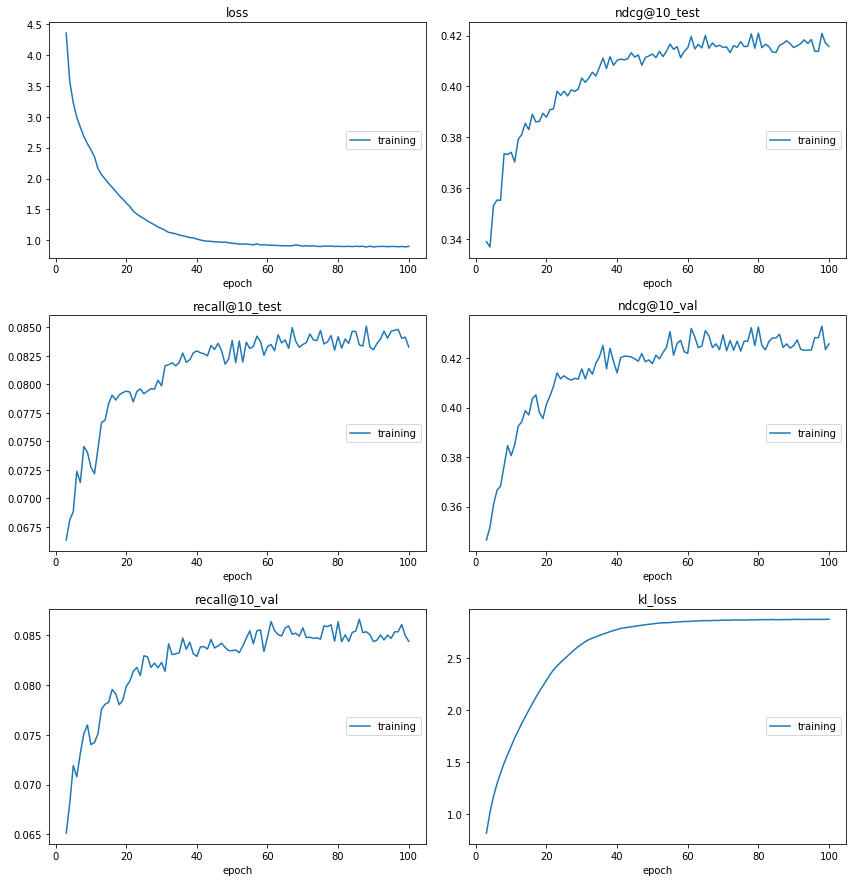

Loss: 0.90035730, lr: 0.000002: 100%|██████████| 100/100 [27:00<00:00, 16.35s/it]

loss:
training   (min:    0.890, max:   15.016, cur:    0.900)

ndcg@10_test:
training   (min:    0.337, max:    0.421, cur:    0.416)

recall@10_test:
training   (min:    0.066, max:    0.085, cur:    0.083)

ndcg@10_val:
training   (min:    0.346, max:    0.433, cur:    0.426)

recall@10_val:
training   (min:    0.065, max:    0.087, cur:    0.084)

kl_loss:
training   (min:    0.229, max:    2.876, cur:    2.876)
Program running time:1621 seconds
Final Resource Usage Peak    -- CPU_load_max:3050.500% memoryUsed_max:1.472GB 
Final Resource Usage Average -- CPU_load_avg:913.258% memoryUsed_avg:1.345GB 


{'map@5': 0.03345692599460733, 'ndcg@5': 0.43463063755403847, 'precision@5': 0.4174636174636175, 'recall@5': 0.04770929398381721, 'map@10': 0.049275177141461825, 'ndcg@10': 0.4138245317529688, 'precision@10': 0.3902806652806653, 'recall@10': 0.08480695138240484, 'map@20': 0.07440794970167168, 'ndcg@20': 0.4008185773363458, 'precision@20': 0.36829521829521833, 'recall@20': 0.1516318844100394}
create new result_file: result/result.csv
{'map@5': 0.03441955297131021, 'ndcg@5': 0.44113326065866054, 'precision@5': 0.4218295218295218, 'recall@5': 0.04806792739511021, 'map@10': 0.05010984258471076, 'ndcg@10': 0.41631330284024853, 'precision@10': 0.3902806652806653, 'recall@10': 0.0834488133927146, 'map@20': 0.07530261395736958, 'ndcg@20': 0.40256433419919724, 'precision@20': 0.3680873180873181, 'recall@20': 0.15126779980684635}
result/result.csv  already exists, appending result to it
{'map@5': 0.034560135345432244, 'ndcg@5': 0.43850528715468845, 'precision@5': 0.4197505197505197, 'recall@5': 

In [6]:
para_str = str(PERCENT)+"_"+str(N_SAMPLE)+"_"+str(MODEL)+"_"+str(EMB_DIM)+"_"+str(LAT_DIM)+"_"+str(INIT_LR)+"_"+OPTI+"_"+str(ALPHA)
model_str = "VBCAR"+DATASET+para_str+"_"+item_fea_type
DEVICE_ID_LIST = GPUtil.getAvailable(order='memory', limit=3)# get the fist gpu with the lowest load
model_save_dir = output_dir+model_str+'.pt'

if len(DEVICE_ID_LIST)<1:
    gpu_id = None
    os.environ["CUDA_VISIBLE_DEVICES"]= ''
    device_str = 'cpu'
else:
    gpu_id = DEVICE_ID_LIST[0]
#     os.environ["CUDA_VISIBLE_DEVICES"]= '0,1,2'
    device_str = 'cuda:'+str(DEVICE_ID_LIST[0])
monitor = Monitor(1,gpu_id,os.getpid())

data_loader = DataLoader(Tensor(train_Triples), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

"""
init model
"""
print("init model ", MODEL)
vbcar = VBCAR(
    data_loader,
    data,
    model_save_dir,
    n_users,
    n_items,
    n_neg=5,
    emb_dim=EMB_DIM,
    latent_dim=LAT_DIM,
    batch_size=BATCH_SIZE,
    initial_lr=INIT_LR,
    activator="tanh",
    iteration=EPOCH,
    optimizer_type=OPTI,
    alpha=ALPHA,
    model_str=MODEL,
    show_result=True,
    device_str=device_str
)
print("strat traning... ")
vbcar.train()
# vbcr.save_embedding(embedding_save_dir)
run_time = monitor.stop()
evaluate(data,vbcar)

## Prediction on test set

In [7]:
total_result = pd.read_csv(result_file)
total_result

,map@5,ndcg@5,precision@5,recall@5,map@10,ndcg@10,precision@10,recall@10,map@20,ndcg@20,...,PERCENT,N_SAMPLE,MODEL,LAT_DIM,EMB_DIM,INIT_LR,BATCH_SIZE,OPTI,ALPHA,REMARKS
0,0.033457,0.434631,0.417464,0.047709,0.049275,0.413825,0.390281,0.084807,0.074408,0.400819,...,1,10000,VAE,256,64,0.001,256,RMSprop,0.01,demo
1,0.034420,0.441133,0.421830,0.048068,0.050110,0.416313,0.390281,0.083449,0.075303,0.402564,...,1,10000,VAE,256,64,0.001,256,RMSprop,0.01,demo
2,0.034560,0.438505,0.419751,0.048107,0.050752,0.418189,0.393867,0.084604,0.075805,0.402288,...,1,10000,VAE,256,64,0.001,256,RMSprop,0.01,demo
3,0.034213,0.438804,0.421414,0.047935,0.049977,0.416421,0.391892,0.083674,0.075286,0.402300,...,1,10000,VAE,256,64,0.001,256,RMSprop,0.01,demo
4,0.034120,0.438707,0.420998,0.047610,0.050042,0.416964,0.392568,0.083395,0.074981,0.401300,...,1,10000,VAE,256,64,0.001,256,RMSprop,0.01,demo
5,0.034813,0.440214,0.423077,0.049699,0.050162,0.415841,0.390904,0.083500,0.075059,0.400564,...,1,10000,VAE,256,64,0.001,256,RMSprop,0.01,demo
6,0.035628,0.446454,0.427859,0.049063,0.051307,0.420839,0.394647,0.084053,0.076308,0.403685,...,1,10000,VAE,256,64,0.001,256,RMSprop,0.01,demo
7,0.034146,0.442755,0.425468,0.049203,0.049942,0.417986,0.392931,0.085164,0.074933,0.402044,...,1,10000,VAE,256,64,0.001,256,RMSprop,0.01,demo
8,0.034795,0.439788,0.421310,0.048378,0.050153,0.415772,0.390125,0.083275,0.075251,0.401760,...,1,10000,VAE,256,64,0.001,256,RMSprop,0.01,demo
9,0.034502,0.439931,0.422557,0.048203,0.050330,0.416921,0.392516,0.084099,0.075329,0.401719,...,1,10000,VAE,256,64,0.001,256,RMSprop,0.01,demo


In [8]:
vbcar.load_best_model()

VAE(
  (fc_u_1): Linear(in_features=512, out_features=256, bias=True)
  (fc_u_2): Linear(in_features=256, out_features=128, bias=True)
  (fc_i_1): Linear(in_features=512, out_features=256, bias=True)
  (fc_i_2): Linear(in_features=256, out_features=128, bias=True)
)